In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import DBSCAN
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn import preprocessing 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})
# Create a figure with a specific size

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df_train = pd.read_csv("playground-series-s4e1/train.csv")
df_test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [3]:
df = pd.concat([df_test,df_train])
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275057 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               275057 non-null  int64  
 1   CustomerId       275057 non-null  int64  
 2   Surname          275057 non-null  object 
 3   CreditScore      275057 non-null  int64  
 4   Geography        275057 non-null  object 
 5   Gender           275057 non-null  object 
 6   Age              275057 non-null  float64
 7   Tenure           275057 non-null  int64  
 8   Balance          275057 non-null  float64
 9   NumOfProducts    275057 non-null  int64  
 10  HasCrCard        275057 non-null  float64
 11  IsActiveMember   275057 non-null  float64
 12  EstimatedSalary  275057 non-null  float64
 13  Exited           165034 non-null  float64
dtypes: float64(6), int64(5), object(3)
memory usage: 31.5+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
#encoding Gender
label_encoder = preprocessing.LabelEncoder() 
df['Gender']= label_encoder.fit_transform(df['Gender']) 

#encoding Geography
label_encoder = preprocessing.LabelEncoder() 
df['Geography']= label_encoder.fit_transform(df['Geography']) 

In [7]:
#Drop Unwanted Columns
df = df.drop(columns=['id', 'Surname','CustomerId'])
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0.0
165030,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45,0.0
165031,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56,0.0
165032,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0.0


<Axes: >

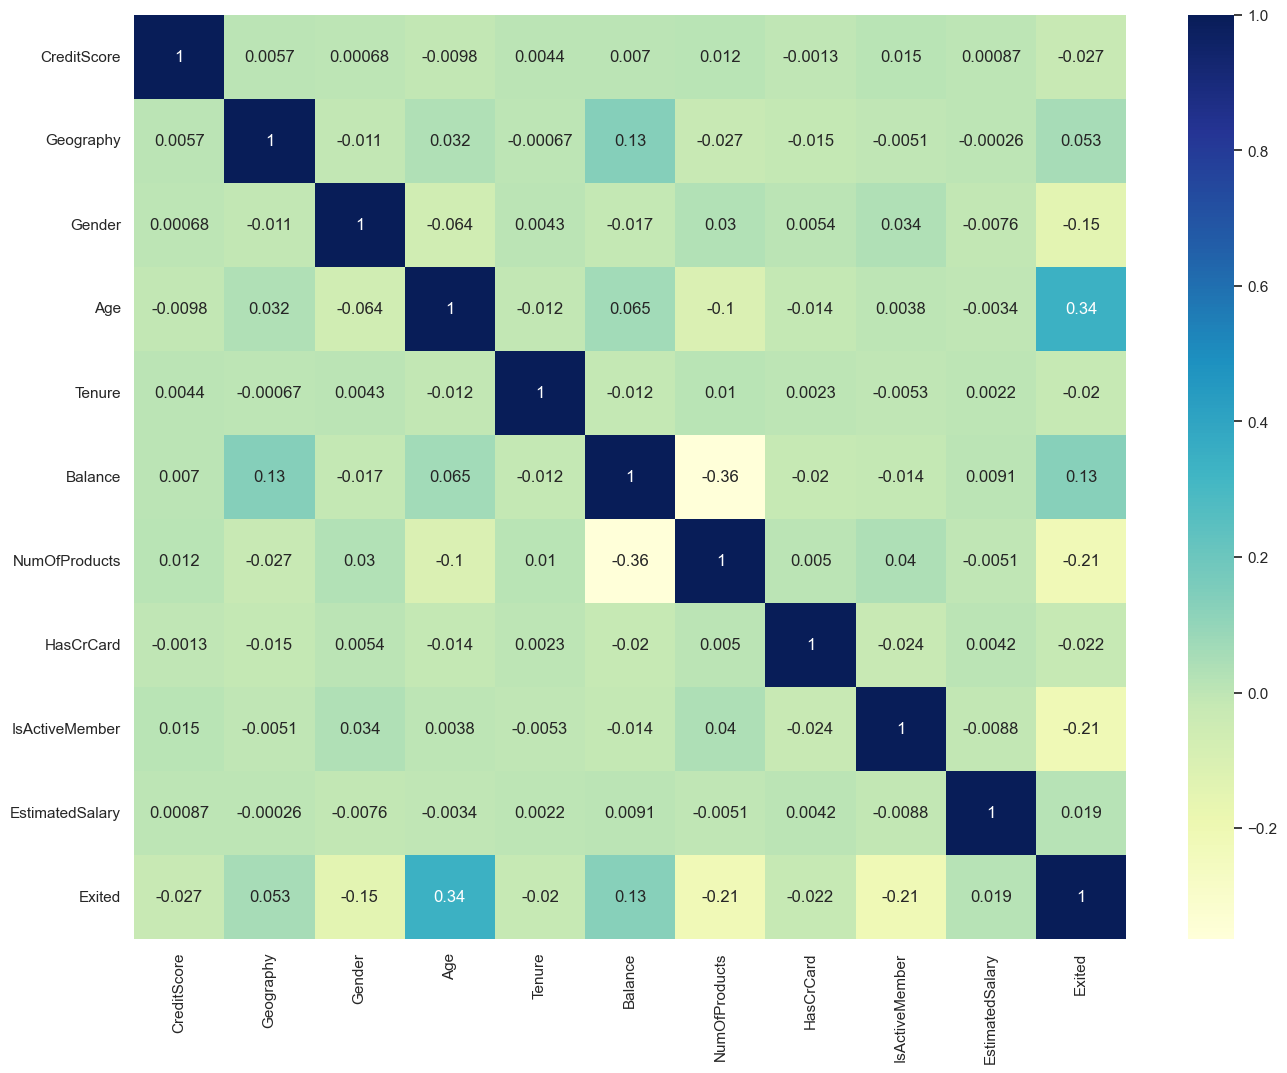

In [8]:
#Understanding the General Data
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 
  

# Observations:
## High Corr:
    1. Age , Exited
    2. Gender, Exited
    3. Num of Products, Exited
    4. Active Member, Exited

In [9]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0.0
165030,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45,0.0
165031,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56,0.0
165032,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0.0


In [10]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the DataFrame (learns the mean and standard deviation)
scaler.fit(df)

# Transform the DataFrame using the learned scaling parameters
df_scaled = scaler.transform(df)

# If you want the result as a DataFrame:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.878997,-0.792217,-1.137018,-1.706099,-1.072946,-0.882407,0.816582,-1.748789,1.006511,0.964589,NaN
1,0.330661,-0.792217,-1.137018,0.888400,-1.072946,-0.882407,-1.014326,0.571824,-0.993531,-0.793884,NaN
2,-0.006048,-0.792217,-1.137018,-0.465252,0.708843,-0.882407,0.816582,0.571824,-0.993531,0.525213,NaN
3,0.305720,-0.792217,0.879493,-0.239643,1.065201,-0.882407,-1.014326,0.571824,-0.993531,0.029046,NaN
4,1.191140,0.433365,0.879493,-0.014035,1.777917,1.048363,-1.014326,0.571824,-0.993531,0.536129,NaN
...,...,...,...,...,...,...,...,...,...,...,...
275052,0.131130,1.658947,-1.137018,-0.578056,-1.072946,-0.882407,-1.014326,0.571824,1.006511,0.385069,-0.518063
275053,1.689968,-0.792217,0.879493,-0.352447,-0.716588,-0.882407,-1.014326,-1.748789,-0.993531,0.385063,-0.518063
275054,-1.140881,-0.792217,0.879493,-0.803665,-0.003872,-0.882407,-1.014326,0.571824,1.006511,0.297468,-0.518063
275055,-1.278059,1.658947,-1.137018,-0.916469,0.708843,1.689536,-1.014326,-1.748789,1.006511,-0.821252,-0.518063


# Preparing data for Training

In [11]:
df_train_model = df[df['Exited'].notnull()]
df_test_model = df[df['Exited'].isnull()]

In [12]:

X = df_train_model.drop("Exited", axis=1)
y = df_train_model["Exited"]
X_test = df_test_model.drop("Exited", axis=1)

# Preparing The Models:

# XGBoost Classifier

In [13]:
lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 1000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1, 
                          })
xgb  = XGBClassifier(**{  'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : 42,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.05,
                          'max_depth'             : 10,
                          'n_estimators'          : 1000,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'verbosity'             : 0,
                         })
cat  = CatBoostClassifier(**{
                         'iterations'            : 10000,
                         'objective'             : 'Logloss',
                         'eval_metric'           : "AUC",
                         'early_stopping_rounds' : 1000,
                         'bagging_temperature'   : 0.1,
                         'colsample_bylevel'     : 0.88,
                         'iterations'            : 1000,
                         'learning_rate'         : 0.05,
                         'max_depth'             : 7,
                         'l2_leaf_reg'           : 1,
                         'min_data_in_leaf'      : 25,
                         'random_strength'       : 0.1, 
                         'max_bin'               : 100,
                         'verbose'               : 0,
                        })
rf = RandomForestClassifier(**{
                        'n_estimators'           :800,
                        'random_state'           :42,
                        'verbose'                :0
    }) 

ada = AdaBoostClassifier(**{
                        'n_estimators'              :1000,
                        'random_state'              :42,
                        'learning_rate'             :0.5,
    })

eTree = ExtraTreeClassifier(**{
                        'criterion' : 'entropy',
                        'random_state'              :42,
                        'max_depth'                 :7,
                        'splitter':'best',
                        'max_features': 'log2',
                        })

vote = VotingClassifier(estimators=[('lgbm', lgbm), ('xgb', xgb), ('cat', cat),('eTree', eTree),('ada', ada)], voting='soft', weights=[1, 1, 1, 2, 1], verbose=True)
#vote = VotingClassifier(estimators=[('eTree', eTree)], voting='soft', weights=[1], verbose=True)



In [14]:
# Initialize an empty array to hold the submission predictions
submission_predictions = []

#kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
kf = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)


In [15]:
# save aucs
aucs = []
for train_index, test_index in kf.split(X, y):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    vote.fit(X_train_kf, y_train_kf)

    # Predict probabilities for validation set
    y_pred_val = vote.predict_proba(X_val_kf)[:, 1]

    # Calculate AUC for validation set
    auc_val = roc_auc_score(y_val_kf, y_pred_val)
    aucs.append(auc_val)

    # Predict probabilities for test set (df_test)
    y_pred_test = vote.predict_proba(X_test)[:, 1]
    submission_predictions.append(y_pred_test)
    print()

[Voting] ..................... (1 of 5) Processing lgbm, total=   7.5s
[Voting] ...................... (2 of 5) Processing xgb, total=   7.5s
[Voting] ...................... (3 of 5) Processing cat, total=  43.2s
[Voting] .................... (4 of 5) Processing eTree, total=   0.1s
[Voting] ...................... (5 of 5) Processing ada, total= 1.1min

[Voting] ..................... (1 of 5) Processing lgbm, total=   6.3s
[Voting] ...................... (2 of 5) Processing xgb, total=   6.5s
[Voting] ...................... (3 of 5) Processing cat, total=  33.9s
[Voting] .................... (4 of 5) Processing eTree, total=   0.1s
[Voting] ...................... (5 of 5) Processing ada, total= 1.1min

[Voting] ..................... (1 of 5) Processing lgbm, total=   6.9s
[Voting] ...................... (2 of 5) Processing xgb, total=   7.0s
[Voting] ...................... (3 of 5) Processing cat, total=  36.1s
[Voting] .................... (4 of 5) Processing eTree, total=   0.1s
[Vot

In [16]:
for i, score in enumerate(aucs):
    print(f"AUC for validation set {i}: {score}")

# Average predictions from different folds
avg_submission = pd.DataFrame(submission_predictions).mean(axis=0)

submission["Exited"] = avg_submission

# Save submission to CSV
submission.to_csv("submission.csv", index=False)

submission.head()

AUC for validation set 0: 0.8826572793395503
AUC for validation set 1: 0.8833142437867225
AUC for validation set 2: 0.8848847871933723
AUC for validation set 3: 0.8833435731680352
AUC for validation set 4: 0.8833967651061759


,id,Exited
0,165034,0.103333
1,165035,0.756453
2,165036,0.133380
3,165037,0.230219
4,165038,0.315667
